<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/XGBoost%E3%82%92optuna%E3%81%A7%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%97%E3%81%A6titanic%E3%82%92%E8%A7%A3%E3%81%8F%20-%20Qiita.pdf-201904151640.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://qiita.com/kuroneko-hornet/items/9e3e8ffba75c1dbf11c6
# XGBoostをoptunaでチューニングしてtitanicを解く

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matchbou","key":"fb2093338e9cd630d62e0949908398dc"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
# kaggleデータ置き場とjupyernoteのカレントディレクトリフォルダを作成

!mkdir ./input
!mkdir ./notebook
!pwd
!ls -a

/content
.  ..  .config	input  kaggle.json  notebook  sample_data


In [11]:
#osライブラリ読込してinputに移動⇒kaggleデータもダウンロード　⇒ notebookフォルダに移動
import os
os.chdir('input')

#https://www.kaggle.com/c/titanic/data
!kaggle competitions download -c titanic

os.chdir('../notebook')


  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 16.3MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.1MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.81MB/s]


In [12]:
!pwd
!ls -a

/content/notebook
.  ..


In [13]:
#上記操作の結果以下のディレクトリ配置となる

# /content/notebook このipynbのカレントディレクトリ
# /content/input カグルからダウンロードしたcsvファイルの置き場所

!pwd
!ls -a ../input


/content/notebook
.  ..  gender_submission.csv  test.csv	train.csv


In [0]:
#ここからカーネルの内容に踏み込む

In [0]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
def preprocess(df):
    df['Fare'] = df ['Fare'].fillna(df['Fare'].mean())
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Embarked'] = df['Embarked'].fillna('Unknown')
    df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    df['Embarked'] = df['Embarked'].map( {'S':0,'C':1,'Q':2,'Unknown':3} ).astype(int)
    df = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)
    return df

In [0]:
#方針1(xgboostのみ)

def train(df,max_depth,learning_rate,num_round):
    train_x = df.drop('Survived',axis=1)
    train_y = df.Survived
    dtrain = xgb.DMatrix(train_x,label=train_y)
    param = { 'max_depth':max_depth,'learning_rate':learning_rate,'objective':'reg:logistic' }
    bst = xgb.train(param,dtrain,num_round)
    return bst

In [0]:
#方針1(xgboostのみ)

def predict(bst,df):
    return bst.predict(xgb.DMatrix(df))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

train score : 0.854614412136536
test score : 0.85


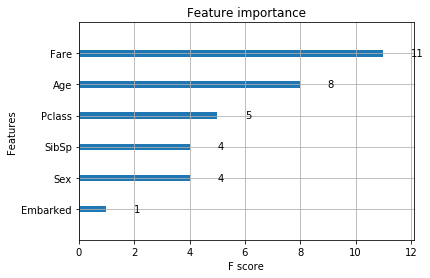

In [100]:
#方針1(xgboostのみ)
  df_original = pd.read_csv("../input/train.csv")
  df_test = preprocess(df_original.tail(100))
  df_train = preprocess(df_original.head(791))
  y = df_test['Survived']
  df_test = df_test.drop('Survived',axis=1)

  max_depth = 3
  learning_rate = 0.6
  round_num = 5

  bst = train(df_train,max_depth,learning_rate,round_num)
  answer = predict(bst,df_train.drop('Survived',axis=1)).round().astype(int)
  print('train score :',accuracy_score(answer.round(),df_train['Survived']))
  answer = predict(bst,df_test).round().astype(int)
  xgb.plot_importance(bst)
  print('test score :',accuracy_score(answer.round(),y))

In [102]:
!pip install optuna

In [0]:
from functools import partial
import optuna


In [0]:
#方針2(xgboost+optuna)

def objective(df, df_test, y,trial):
  #目的関数
  max_depth = trial.suggest_int('max_depth',1,30)
  learning_rate = trial.suggest_uniform('learning_rate',0.0,1)
  round_num = trial.suggest_int('round_num',1,30)
  #bst = train(df,max_depth,learning_rate,round_num,gamma,min_childe_weigh,subsample,colsample_bytree,alpha,lamb)
  bst = train(df,max_depth,learning_rate,round_num)
  answer = predict(bst,df_test).round().astype(int)
  score = accuracy_score(answer.round(),y)
  return 1.0 - score

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve


params : {'max_depth': 21, 'learning_rate': 0.24660152787920614, 'round_num': 15}
train score : 0.9254108723135271
test score : 0.89


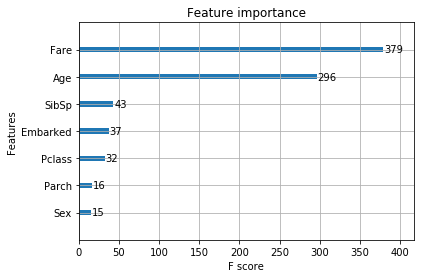

In [105]:
#方針2(xgboost+optuna)



df_original = pd.read_csv("../input/train.csv")
df_test = preprocess(df_original.tail(100))
df_train = preprocess(df_original.head(791))
y = df_test['Survived']
df_test = df_test.drop('Survived',axis=1)

#optunaの前処理
obj_f = partial(objective, df_train, df_test, y)

#セッション作成
study = optuna.create_study()

#回数
study.optimize(obj_f, n_trials=100)


max_depth = study.best_params['max_depth']
learning_rate = study.best_params['learning_rate']
round_num = study.best_params['round_num']


bst = train(df_train,max_depth,learning_rate,round_num)
print('\nparams :',study.best_params)
answer = predict(bst,df_train.drop('Survived',axis=1)).round().astype(int)
print('train score :',accuracy_score(answer.round(),df_train['Survived']))
answer = predict(bst,df_test).round().astype(int)
xgb.plot_importance(bst)
print('test score :',accuracy_score(answer.round(),y))


In [0]:
#以下最適化するパラメータ数を増やす部分は未解決

In [0]:
def train03(df,max_depth,learning_rate,num_round,gamma,min_childe_weigh,colsample_bytree,alpha):
    train_x = df.drop('Survived',axis=1)
    train_y = df.Survived
    dtrain = xgb.DMatrix(train_x,label=train_y)
    param = { 'max_depth':max_depth,'learning_rate':learning_rate,'objective':'reg:logistic', 'gamma':gamma,'min_childe_weigh':min_childe_weigh,'colsample_bytree':colsample_bytree,'alpha':alpha}
    bst = xgb.train(param,dtrain,num_round,gamma,min_childe_weigh,colsample_bytree,alpha)
    return bst

In [0]:
#方針3(xgboost+optunaで沢山パラメータチューニング)

def objective03(df, df_test, y,trial):
  #目的関数
  max_depth = trial.suggest_int('max_depth',1,30)
  learning_rate = trial.suggest_uniform('learning_rate',0.0,1)
  round_num = trial.suggest_int('round_num',1,30)
  
  gamma = trial.suggest_uniform('gamma',0,1)
  min_childe_weigh = trial.suggest_uniform('min_childe_weigh',0,1)
  #subsample = trial.suggest_uniform('subsample',0,1)
  colsample_bytree = trial.suggest_uniform('colsample_bytree',0,1)
  alpha = trial.suggest_uniform('alpha',0,1)
  #lamb = trial.suggest_uniform('lamb',0,1) 
  
  
  #bst = train(df,max_depth,learning_rate,round_num,gamma,min_childe_weigh,subsample,colsample_bytree,alpha,lamb)
  #bst = train(df,max_depth,learning_rate,round_num)
  bst = train03(df,max_depth,learning_rate,round_num,gamma,min_childe_weigh,colsample_bytree,alpha)
  
  
  answer = predict(bst,df_test).round().astype(int)
  score = accuracy_score(answer.round(),y)
  return 1.0 - score

In [109]:
#方針3(xgboost+optunaで沢山パラメータチューニング)
df_original = pd.read_csv("../input/train.csv")
df_test = preprocess(df_original.tail(100))
df_train = preprocess(df_original.head(791))
y = df_test['Survived']
df_test = df_test.drop('Survived',axis=1)

#optunaの前処理
obj_f03 = partial(objective03, df_train, df_test, y)

#セッション作成
study03 = optuna.create_study()

#回数
study03.optimize(obj_f03, n_trials=100)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [110]:
max_depth = study03.best_params['max_depth']
learning_rate = study03.best_params['learning_rate']
round_num = study03.best_params['round_num']

gamma = study03.best_params['gamma']
min_childe_weigh = study03.best_params['min_childe_weigh']
colsample_bytree = study03.best_params['colsample_bytree']
alpha = study03.best_params['alpha']


ValueError: ignored

In [111]:


bst = train(df_train,max_depth,learning_rate,round_num,gamma,min_childe_weigh,colsample_bytree,alpha)
print('\nparams :',study.best_params)
answer = predict(bst,df_train.drop('Survived',axis=1)).round().astype(int)
print('train score :',accuracy_score(answer.round(),df_train['Survived']))
answer = predict(bst,df_test).round().astype(int)
xgb.plot_importance(bst)
print('test score :',accuracy_score(answer.round(),y))


TypeError: ignored